In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = df_train.copy()
df_train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [56]:
df_train.shape

(19237, 18)

In [57]:
df_test.shape

(8245, 18)

In [58]:
df_train.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8245 entries, 0 to 8244
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8245 non-null   int64  
 1   Levy              8245 non-null   object 
 2   Manufacturer      8245 non-null   object 
 3   Model             8245 non-null   object 
 4   Prod. year        8245 non-null   int64  
 5   Category          8245 non-null   object 
 6   Leather interior  8245 non-null   object 
 7   Fuel type         8245 non-null   object 
 8   Engine volume     8245 non-null   object 
 9   Mileage           8245 non-null   object 
 10  Cylinders         8245 non-null   int64  
 11  Gear box type     8245 non-null   object 
 12  Drive wheels      8245 non-null   object 
 13  Doors             8245 non-null   object 
 14  Wheel             8245 non-null   object 
 15  Color             8245 non-null   object 
 16  Airbags           8245 non-null   int64  


In [61]:
df_train.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [62]:


train_df = pd.read_csv('train.csv')
TARGET = 'Price'

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(TARGET)
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()

y = train_df[TARGET]
if y.skew() > 0.75:
    y_trans = np.log1p(y)
    target_transform = 'log1p'
else:
    y_trans = y
    target_transform = None

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=50)),
    ('regressor', GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(columns=[TARGET]), y_trans, test_size=0.2, random_state=42
)


model.fit(X_train, y_train)

y_pred_trans = model.predict(X_test)
if target_transform == 'log1p':
    y_pred = np.expm1(y_pred_trans)
    y_true = np.expm1(y_test)
else:
    y_pred = y_pred_trans
    y_true = y_test

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\nFINAL MODEL PERFORMANCE")
print(f"R² Score : {r2:.4f}")



FINAL MODEL PERFORMANCE
R² Score : 0.3009


📈 Original Skewness:
ID                       : -11.868
Prod. year               : -2.082
Cylinders                : 2.091
Airbags                  : 0.082


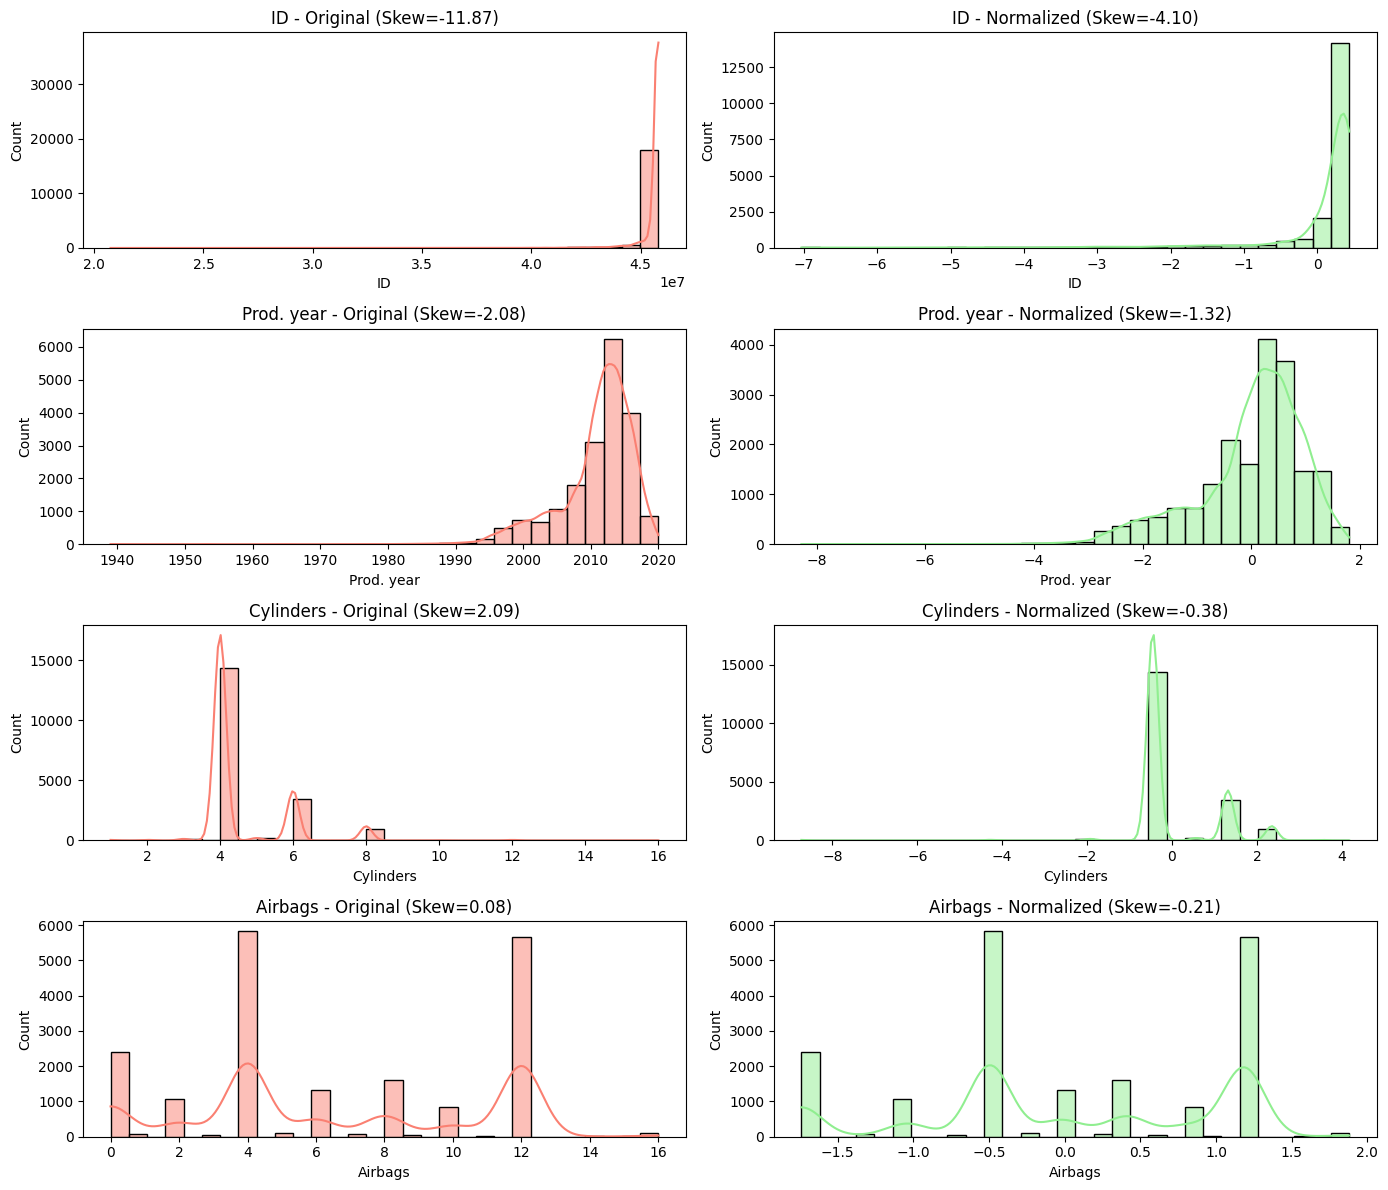


✅ Skewness Comparison (Before → Normalized):
ID                       : Before=-11.868 → After= -4.100
Prod. year               : Before= -2.082 → After= -1.316
Cylinders                : Before=  2.091 → After= -0.384
Airbags                  : Before=  0.082 → After= -0.210


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler

train_df = pd.read_csv("train.csv")


numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()


if 'Price' in numeric_cols:
    numeric_cols.remove('Price')

print("📈 Original Skewness:")
for col in numeric_cols:
    sk = train_df[col].dropna().skew()
    print(f"{col:25s}: {sk:.3f}")

pt = PowerTransformer(method='yeo-johnson')
df_skew_corrected = train_df.copy()
df_skew_corrected[numeric_cols] = pt.fit_transform(train_df[numeric_cols].fillna(train_df[numeric_cols].median()))


scaler = StandardScaler()
df_normalized = df_skew_corrected.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df_skew_corrected[numeric_cols])

plt.figure(figsize=(14, len(numeric_cols)*3))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 2, 2*i + 1)
    sns.histplot(train_df[col], kde=True, color='salmon', bins=30)
    plt.title(f"{col} - Original (Skew={train_df[col].skew():.2f})")

    plt.subplot(len(numeric_cols), 2, 2*i + 2)
    sns.histplot(df_normalized[col], kde=True, color='lightgreen', bins=30)
    plt.title(f"{col} - Normalized (Skew={df_normalized[col].skew():.2f})")

plt.tight_layout()
plt.show()

print("\nSkewness Comparison (Before → Normalized):")
for col in numeric_cols:
    before = train_df[col].dropna().skew()
    after = df_normalized[col].dropna().skew()
    print(f"{col:25s}: Before={before:7.3f} → After={after:7.3f}")


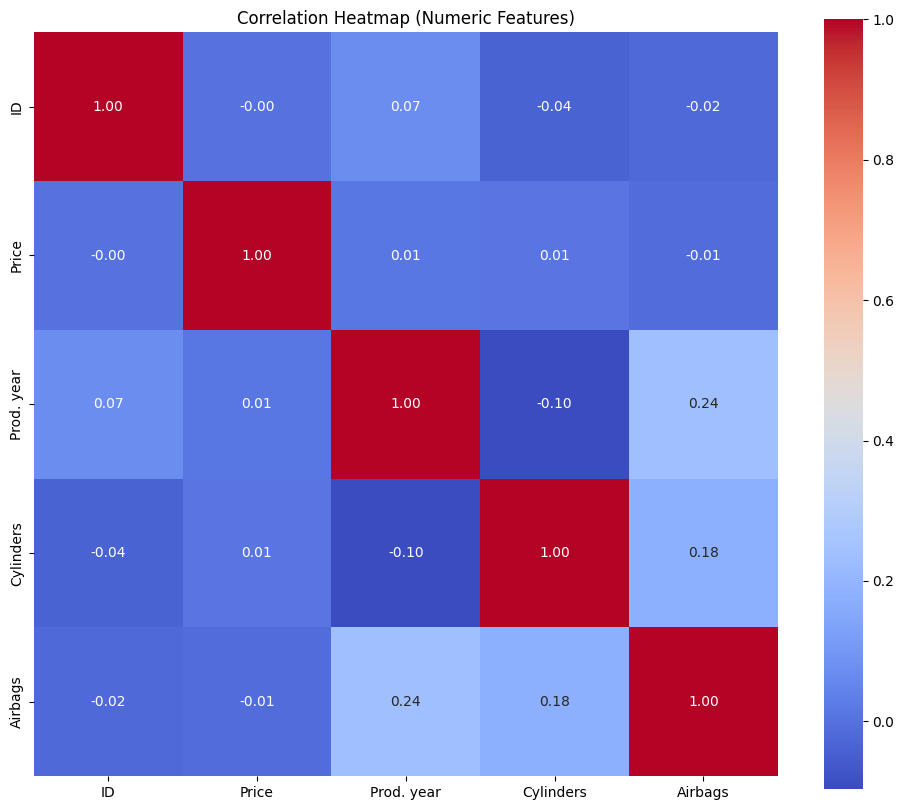

In [75]:
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()

corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()